# Run the block to import libraries by pressing Shift and Enter at the same time.

In [668]:
import pandas as pd
import trueskill as ts
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

# No need to run anything from here until the next section.

In [764]:
winner_cols = ['WPlayer1', 'WPlayer2', 'WPlayer3', 'WPlayer4', 'WPlayer5']
loser_cols = ['LPlayer1', 'LPlayer2', 'LPlayer3', 'LPlayer4', 'LPlayer5']

player_cols = winner_cols + loser_cols
relevant_cols = ['Map', 'Date', 'Score', 'Team'] + winner_cols + loser_cols

In [766]:
form_df = pd.read_excel("Midair_PUG_tracking (Responses).xlsx", na_filter = False)

In [767]:
region = 'AUS'

form_df = pd.read_excel("Midair_PUG_tracking (Responses).xlsx", na_filter = False)
form_df = form_df[form_df['Region'] == region]

loser_df = form_df['Losing players'].str.split(',|:', expand=True)
loser_df.columns = loser_cols
loser_df

winner_df = form_df['Winning players'].str.split(',|:', expand=True)
winner_df.columns = winner_cols

def Score(series):
    return (str(series['Winning Team Score']) + "-" + str(series['Losing Team Score']))
form_df['Score'] = form_df.apply(Score, axis = 1)
form_df.rename(columns={'Winning team': 'Team'}, inplace = True)
players_df = pd.concat([winner_df, loser_df], axis = 1)
form_df = pd.concat([form_df, players_df], axis = 1)
form_df['Date'] = form_df['Date'].apply(pd.to_datetime)

form_df[player_cols] = form_df[player_cols].apply(lambda x: x.str.strip())

In [769]:
if region == 'AUS':
    df = pd.read_excel("cb_jester_results.xlsx")
    bittah_tourny_df = pd.read_excel("bittah_5s_july.xlsx")
    bhp_df = pd.read_excel("Midair Games.xlsx", sheet_name = 'Sheet2')
    df = pd.concat([df, bittah_tourny_df, bhp_df, form_df[relevant_cols]], axis = 0, sort = False)
    df[player_cols] = df[player_cols].apply(lambda x: x.astype(str).str.lower().str.strip())
    df.replace({'petgen': 'petty', 'rr': 'devik', 'hobb': 'nasty hobbit', 'xu1':'xui', 'colonel blair':'cb', \
                'rulefuckdoseplease':'kroz', 'raging moose': 'raging', 'launchair':'laun', 'ultralpb': 'damo', \
                'rr': 'devik',}, inplace = True)
if region == 'NA':
    tea_df = pd.read_excel("tea_games.xlsx")
    sharp_df = pd.read_excel("Midair Games.xlsx")[tea_df.columns[:-1]]
    byo5_df = pd.read_excel("byo5_jp.xlsx")
    stork_df = pd.read_excel("stork_stats.xlsx")
    yami_df = pd.read_excel("yami_moth.xlsx")
    lockjaw_fyr_df = pd.read_excel("lockjaw_fyr.xlsx")
    df = pd.concat([tea_df, sharp_df, byo5_df, stork_df, yami_df, lockjaw_fyr_df], axis = 0, sort = False)
    df = pd.concat([df, form_df], axis = 0, sort = False).copy()
    df[player_cols] = df[player_cols].apply(lambda x: x.astype(str).str.lower())

    player_dict = ['stork', 'sparkle', 'scar', 'iced', 'b3d', 'bed', 'pika', 'icehawk', 'debug', 'joe', \
               'implo', 'dae', 'jon osc', 'skip', 'ringo', 'sharp', 'ramses', 'jimmy', 'yods', 'chem', \
               'lock', 'void', 'mista b', 'osc', 'anarchy', 'tyler']

    for player in player_dict:
        df[player_cols] = df[player_cols].replace({'(.*)' + player + '(.*)': player}, regex = True)

    df[player_cols] = df[player_cols].replace({'couch' : 'boris', 'b3d':'bed', 'cargo': 'esprit', 'pissface': 'giohm', 'osc': 'immie', \
             'v23': 'v22', 'patrick': 'dae', 'pat': 'moose', 'shreq': 'schreq', \
           'bootswfur|synergizer bunny|ludang|total|sun dog|vitalica|loanwolf32|jeffreee|wristfracture|swoot|kevinator|intense|kromatic|superfam|cykon|chocotaco|debug|sauon|jfw20|wrightrj|hasslehof|cohen|extcy|robbie|ramses|mysterium|brotein|germy the syphilis|raybidet|arrow|missd|mcnibbles|riley|pancak3s|bro\.scrubamtiskaw': 'newb', \
           'efx|krayvok|ucan|devil|ragencajuin': 'decent'}, regex = True)



In [770]:
df.to_pickle('AUS_combined_midair_games.p')

# Read in Data
Run everything from here to the bottom by pressing Shift + Enter multiple times. Pay attention to the "profile_player" function

In [774]:
region = 'AUS' # change this to NA or AUS for whichever region you want
df = pd.read_pickle(region + '_combined_midair_games.p')


In [775]:
def str_winning_team(series):
    return str(sorted(series[winner_cols]))
df['str_winning_team'] = df.apply(str_winning_team, axis = 1)


def str_losing_team(series):
    return str(sorted(series[loser_cols]))
df['str_losing_team'] = df.apply(str_losing_team, axis = 1)

df['Date'] = df['Date'].apply(pd.to_datetime)
df['Month'] = df['Date'].dt.month

df.drop_duplicates(subset = ['Month', 'Map', 'Team', 'str_winning_team', 'str_losing_team'], inplace = True)

df[player_cols] = df[player_cols].applymap(str)

players = list(set([item for sublist in df[player_cols].values.tolist() for item in sublist]))

players_ts = dict(zip(players, [ts.Rating() for i in players]))
players_ts_time = {player: [] for player in players}


df = df.sort_values(by = 'Date', ascending = True)

df['Map'] = df['Map'].str.lower()

In [777]:
for i, row in df.iterrows():
    # Find ratings in dictionary
    winner_list = list(row[['WPlayer1', 'WPlayer2', 'WPlayer3', 'WPlayer4', 'WPlayer5']])
    loser_list = list(row[['LPlayer1', 'LPlayer2', 'LPlayer3', 'LPlayer4', 'LPlayer5']])
    t1 = [players_ts[player] for player in winner_list]
    t2 = [players_ts[player] for player in loser_list]
    
    # Get ratings after match
    a, b = (ts.rate([t1, t2], ranks=[0, 1]))
    
    if row['Team'] == 'Tie':
        a, b = (ts.rate([t1, t2], ranks=[0, 0]))

    # Update ratings in dictionary (not necessary to split winners and losers, but easier to read and debug)
    for i, player in enumerate(winner_list):
        players_ts[player] = a[i]
        players_ts_time[player].append(a[i].mu)
    for i, player in enumerate(loser_list):
        players_ts[player] = b[i]
        players_ts_time[player].append(b[i].mu)

In [778]:

sorted_rating_list = sorted(((value.mu, key) for (key,value) in players_ts.items()), reverse = True)

In [779]:
sorted_rating_list

[(33.665057379210495, 'bhp'),
 (32.850372463005115, 'cb'),
 (31.529451142501255, 'rain'),
 (31.38787407624296, 'damo'),
 (31.113252056826237, 'zoidberg'),
 (30.523961711677615, 'godog'),
 (30.4637389652499, 'fyr'),
 (30.055311134299483, 'laun'),
 (29.664102096404918, 'confusion'),
 (29.52481013522987, 'petty'),
 (29.191060713832883, 'spacecake'),
 (29.012075119018228, 'sickfest'),
 (28.93134790134897, 'kustom'),
 (28.828955000072536, 'nonreg'),
 (28.045623092293596, 'devik'),
 (27.623510258100172, 'tyler'),
 (27.347338327160173, 'chem'),
 (26.98293943099393, 'danger'),
 (26.937477455753566, 'bakara'),
 (26.77508075934672, 'ringo'),
 (26.676282462287865, 'raging'),
 (26.331236694595653, 'xui'),
 (26.107944134750124, 'jester'),
 (25.948994007405766, 'xandrax'),
 (25.829831683002325, 'nasty hobbit jester'),
 (25.71852828808842, 'tamtim'),
 (25.622622757774558, 'style'),
 (25.56852879030796, 'dose'),
 (25.33237874891592, 'nasty hobbit devik'),
 (25.19635350590903, 'sajent'),
 (24.784433242

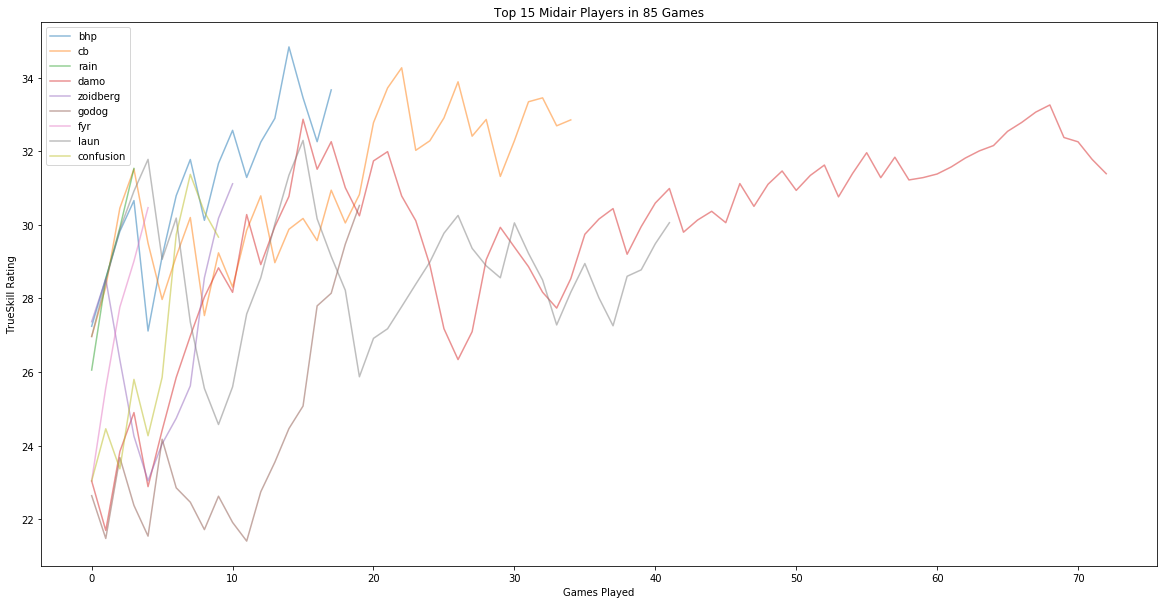

In [780]:
plotted_players = [item[1] for item in sorted_rating_list[0:9]]
plt.figure(figsize=(20,10))
for i, player in enumerate(plotted_players):
    plt.plot(players_ts_time[player], alpha=0.5)
    
plt.title("Top 15 Midair Players in " + str(df.shape[0]) + ' Games')
plt.xlabel('Games Played')
plt.ylabel('TrueSkill Rating')
plt.legend(plotted_players)
plt.show()

In [781]:
rating_sigma_list = sorted(((round(value.mu, 1), round(value.sigma, 1), key) for (key,value) in players_ts.items()), reverse = True)
rating_sigma_list

[(33.7, 5.1, 'bhp'),
 (32.9, 4.4, 'cb'),
 (31.5, 7.5, 'rain'),
 (31.4, 3.2, 'damo'),
 (31.1, 6.1, 'zoidberg'),
 (30.5, 7.1, 'fyr'),
 (30.5, 5.2, 'godog'),
 (30.1, 3.9, 'laun'),
 (29.7, 6.2, 'confusion'),
 (29.5, 3.6, 'petty'),
 (29.2, 7.9, 'spacecake'),
 (29.0, 7.4, 'sickfest'),
 (28.9, 5.4, 'kustom'),
 (28.8, 7.2, 'nonreg'),
 (28.0, 3.7, 'devik'),
 (27.6, 8.0, 'tyler'),
 (27.3, 6.4, 'chem'),
 (27.0, 6.5, 'danger'),
 (26.9, 7.5, 'bakara'),
 (26.8, 6.7, 'ringo'),
 (26.7, 7.2, 'raging'),
 (26.3, 5.3, 'xui'),
 (26.1, 3.6, 'jester'),
 (25.9, 7.8, 'xandrax'),
 (25.8, 7.1, 'nasty hobbit jester'),
 (25.7, 4.7, 'tamtim'),
 (25.6, 7.9, 'style'),
 (25.6, 4.2, 'dose'),
 (25.3, 7.6, 'nasty hobbit devik'),
 (25.2, 7.6, 'sajent'),
 (24.8, 7.8, 'manlover'),
 (24.7, 7.6, 'tekra'),
 (24.7, 7.1, 'cantara'),
 (24.5, 7.1, 'tea'),
 (23.8, 6.9, 'pyre'),
 (23.7, 6.0, 'dae'),
 (23.7, 5.9, 'nexgen'),
 (23.7, 3.8, 'nasty hobbit'),
 (23.5, 5.9, 'bloby'),
 (23.3, 4.8, 'kroz'),
 (23.1, 6.4, 'chemdawg'),
 (22.5, 7.

In [782]:
sorted([(round((item[0] - 1.5*item[1]),2), item[0], item[1], item[2]) for item in rating_sigma_list], reverse = True)

[(26.6, 31.4, 3.2, 'damo'),
 (26.3, 32.9, 4.4, 'cb'),
 (26.05, 33.7, 5.1, 'bhp'),
 (24.25, 30.1, 3.9, 'laun'),
 (24.1, 29.5, 3.6, 'petty'),
 (22.7, 30.5, 5.2, 'godog'),
 (22.45, 28.0, 3.7, 'devik'),
 (21.95, 31.1, 6.1, 'zoidberg'),
 (20.8, 28.9, 5.4, 'kustom'),
 (20.7, 26.1, 3.6, 'jester'),
 (20.4, 29.7, 6.2, 'confusion'),
 (20.25, 31.5, 7.5, 'rain'),
 (19.85, 30.5, 7.1, 'fyr'),
 (19.3, 25.6, 4.2, 'dose'),
 (18.65, 25.7, 4.7, 'tamtim'),
 (18.35, 26.3, 5.3, 'xui'),
 (18.0, 28.8, 7.2, 'nonreg'),
 (18.0, 23.7, 3.8, 'nasty hobbit'),
 (17.9, 29.0, 7.4, 'sickfest'),
 (17.7, 27.3, 6.4, 'chem'),
 (17.35, 29.2, 7.9, 'spacecake'),
 (17.25, 27.0, 6.5, 'danger'),
 (16.75, 26.8, 6.7, 'ringo'),
 (16.1, 23.3, 4.8, 'kroz'),
 (15.9, 26.7, 7.2, 'raging'),
 (15.65, 26.9, 7.5, 'bakara'),
 (15.6, 27.6, 8.0, 'tyler'),
 (15.15, 25.8, 7.1, 'nasty hobbit jester'),
 (14.85, 23.7, 5.9, 'nexgen'),
 (14.7, 23.7, 6.0, 'dae'),
 (14.65, 23.5, 5.9, 'bloby'),
 (14.2, 25.9, 7.8, 'xandrax'),
 (14.05, 24.7, 7.1, 'cantara'

In [783]:
[(item[1], df[winner_cols].isin([item[1]]).any(axis = 1).sum(), df[loser_cols].isin([item[1]]).any(axis = 1).sum()) for item in sorted_rating_list]

[('bhp', 13, 5),
 ('cb', 25, 10),
 ('rain', 4, 0),
 ('damo', 45, 28),
 ('zoidberg', 9, 2),
 ('godog', 10, 10),
 ('fyr', 3, 2),
 ('laun', 25, 17),
 ('confusion', 5, 5),
 ('petty', 26, 29),
 ('spacecake', 1, 0),
 ('sickfest', 3, 1),
 ('kustom', 6, 7),
 ('nonreg', 2, 2),
 ('devik', 27, 24),
 ('tyler', 1, 0),
 ('chem', 5, 5),
 ('danger', 5, 3),
 ('bakara', 3, 1),
 ('ringo', 3, 3),
 ('raging', 3, 2),
 ('xui', 11, 8),
 ('jester', 29, 28),
 ('xandrax', 1, 1),
 ('nasty hobbit jester', 2, 2),
 ('tamtim', 12, 10),
 ('style', 1, 1),
 ('dose', 18, 18),
 ('nasty hobbit devik', 1, 1),
 ('sajent', 2, 1),
 ('manlover', 1, 1),
 ('cantara', 4, 1),
 ('tekra', 1, 1),
 ('tea', 2, 4),
 ('pyre', 3, 2),
 ('nasty hobbit', 23, 23),
 ('nexgen', 7, 8),
 ('dae', 7, 6),
 ('bloby', 6, 8),
 ('kroz', 12, 14),
 ('chemdawg', 4, 4),
 ('moose', 1, 4),
 ('sub ringo', 0, 1),
 ('air', 0, 1),
 ('cyrus', 1, 3),
 ('tektra', 0, 2),
 ('mikehunt', 0, 2),
 ('ambient', 1, 3),
 ('iced', 4, 7),
 ('skewa', 0, 4),
 ('nuts', 12, 17),
 ('

In [784]:
def profile_player(target, partner_list = False, partner = False, opponent_list = False, opponent = False):
    profile_df = df[df[player_cols].isin([target]).any(axis = 1)]
    profile_df
    print (target + "'s record is: " + str(df[winner_cols].isin([target]).any(axis = 1).sum()) + " - " + \
           str(df[loser_cols].isin([target]).any(axis = 1).sum()))
    
    rank_ts = [(i+1, item[0]) for i, item in enumerate(sorted_rating_list) if item[1] == target][0]
    print (target + ' is ranked ' + str(rank_ts[0]) + ' out of ' + str(len(sorted_rating_list)) + \
          ', with TrueSkill score of ' + str(round(rank_ts[1], 3)) + ' and uncertainty of ' + str(round(players_ts[target].sigma, 3)))
    record_df = pd.concat([df[df[winner_cols].isin([target]).any(axis = 1)]['Map'].value_counts(), df[df[loser_cols].isin([target]).any(axis = 1)]['Map'].value_counts()], axis = 1, sort = True)
    record_df.columns = ['Wins', 'Losses']
    record_df.fillna(0, inplace = True)
    record_df.Wins = record_df.Wins.astype(int)
    record_df.Losses = record_df.Losses.astype(int)
    print (record_df)
    
    winner_partners_dict = Counter(df[df[winner_cols].isin([target]).any(axis = 1)][winner_cols].values.flatten())
    loser_partners_dict = Counter(df[df[loser_cols].isin([target]).any(axis = 1)][loser_cols].values.flatten())
    
    if partner_list is not False:
        ds = [winner_partners_dict, loser_partners_dict]
        d = {}
        for k in winner_partners_dict:
            d[k] = tuple(d[k] for d in ds)
            
        for k in loser_partners_dict:
            if k not in d:
                d[k] = tuple(d[k] for d in ds)
        print('\n' + target + "'s record when playing with these players:")
        print(list(zip(sorted(d, key=lambda x: d[x], reverse=True), sorted(d.values(), reverse = True))))

    if partner is not False:
        print ('\n' + target + ' has ' + str(winner_partners_dict[partner]) + ' wins and ' + \
               str(loser_partners_dict[partner]) + ' losses with ' + partner)
        
    winner_vs_opponents_dict = Counter(df[df[winner_cols].isin([target]).any(axis = 1)][loser_cols].values.flatten())
    loser_vs_opponents_dict = Counter(df[df[loser_cols].isin([target]).any(axis = 1)][winner_cols].values.flatten())
    
    if opponent_list is not False:
        ds = [winner_vs_opponents_dict, loser_vs_opponents_dict]
        d = {}
        for k in winner_vs_opponents_dict:
            d[k] = tuple(d[k] for d in ds)
        for k in loser_vs_opponents_dict:
            if k not in d:
                d[k] = tuple(d[k] for d in ds)
        print('\n' + target + "'s record when playing against these players:")
        print(list(zip(sorted(d, key=lambda x: d[x], reverse=True), sorted(d.values(), reverse = True))))
        #print(sorted(d, key=lambda x: d[x], reverse=True))
        
    if opponent is not False:
        print ('\n' + target + ' has ' + str(winner_vs_opponents_dict[opponent]) + ' wins ' + \
               str(loser_vs_opponents_dict[opponent]) + ' losses against ' + opponent)


In [786]:
profile_player(target = 'damo', partner_list = True, partner = 'dae', opponent_list = True, opponent = 'petty')

damo's record is: 45 - 28
damo is ranked 4 out of 57, with TrueSkill score of 31.388 and uncertainty of 3.21
             Wins  Losses
brynhildr       6       6
elite           9       4
exhumed         0       3
hypothermia     2       3
iguana          2       2
ingonyama       4       1
kryosis         8       5
minora         10       2
nightflare      1       0
outpost         3       2

damo's record when playing with these players:
[('damo', (45, 28)), ('devik', (21, 11)), ('jester', (13, 3)), ('cb', (10, 0)), ('laun', (9, 7)), ('dose', (9, 4)), ('bhp', (9, 3)), ('nuts', (8, 6)), ('nasty hobbit', (8, 5)), ('zoidberg', (8, 0)), ('gregyeah', (7, 8)), ('petty', (7, 3)), ('nexgen', (6, 1)), ('godog', (6, 1)), ('kroz', (5, 7)), ('tamtim', (5, 4)), ('xan', (4, 4)), ('tonks', (4, 4)), ('neogenetix', (4, 3)), ('chemdawg', (4, 2)), ('xui', (3, 3)), ('iced', (3, 2)), ('pyre', (3, 1)), ('confusion', (3, 0)), ('bakara', (3, 0)), ('dae', (2, 5)), ('kustom', (2, 2)), ('chem', (2, 1)), ('bloby

In [787]:
import itertools
import math
BETA = 4.1666
def win_probability(team1, team2):
    delta_mu = sum(r.mu for r in team1) - sum(r.mu for r in team2)
    sum_sigma = sum(r.sigma ** 2 for r in itertools.chain(team1, team2))
    size = len(team1) + len(team2)
    denom = math.sqrt(size * (BETA * BETA) + sum_sigma)
    trueskill = ts.global_env()
    return trueskill.cdf(delta_mu / denom)


In [788]:
def win_prob(series):
    return win_probability([players_ts[series['WPlayer1']], players_ts[series['WPlayer2']], players_ts[series['WPlayer3']], \
                     players_ts[series['WPlayer4']], players_ts[series['WPlayer5']]], \
                    [players_ts[series['LPlayer1']], players_ts[series['LPlayer2']], players_ts[series['LPlayer3']], \
                     players_ts[series['LPlayer4']], players_ts[series['LPlayer5']]])

df['win_probability'] = df.apply(win_prob, axis = 1)

In [789]:
def correct_ts_prediction(series):
    return 'Yes' if series['win_probability'] > 0.5 else 'No'
df['correct_ts_prediction'] = df.apply(correct_ts_prediction, axis = 1)

In [790]:
df[df['Team'] != 'Tie']['correct_ts_prediction'].value_counts()

Yes    69
No     12
Name: correct_ts_prediction, dtype: int64

In [791]:
# win_probability([players_ts['sharp'], players_ts['joe'], players_ts['moose'], players_ts['implo'], players_ts['icehawk']],\
#                 [players_ts['dl'], players_ts['stork'], players_ts['berserker'], players_ts['logic'], players_ts['sin']])

KeyError: 'sharp'